In [1]:
from CNNBiLSTM_LoadData import load_data
from tensorflow.keras.utils import to_categorical
import numpy as np

data_batches = load_data('VideoFrameAudio-Simple-40')

for item in data_batches:
    normalized_images = [image_data / 255.0 for image_data in item['images']]
    item['images'] = np.array(normalized_images)

from tensorflow.keras.utils import to_categorical
image_data = [item['images'] for item in data_batches]
image_data = np.array(image_data)

audio_data = [item['audio'] for item in data_batches]
audio_data = np.array(audio_data).reshape(-1,10,128)
print(f"shape {audio_data.shape}")

categories = [item['category'] for item in data_batches]
categories = np.array(categories)
num_classes = len(np.unique(categories))
labels = to_categorical(categories, num_classes)

2024-01-05 02:16:56.648304: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-05 02:16:56.723359: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-05 02:16:57.785130: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


categories ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad']
start process Anger all imagefiles 2667 all audiofiles 2667
start process Disgust all imagefiles 2793 all audiofiles 2793
start process Fear all imagefiles 2369 all audiofiles 2369
start process Happy all imagefiles 2231 all audiofiles 2231
start process Neutral all imagefiles 2124 all audiofiles 2124
start process Sad all imagefiles 2511 all audiofiles 2511
process all files
shape (1467, 10, 128)


In [1]:
np.save('image_data.npy',image_data)
np.save('audio_data.npy',audio_data)
np.save('labels.npy',labels)

NameError: name 'np' is not defined

In [1]:
import numpy as np
image_data = np.load('image_data.npy')
audio_data = np.load('audio_data.npy')
labels = np.load('labels.npy')

In [2]:
from keras.models import Model
from keras.layers import Input, Concatenate, Dense,Bidirectional, LSTM,TimeDistributed
from keras.optimizers import Adam
import tensorflow as tf


# 加载预训练模型
pretrained_cnn_bilstm_image = tf.keras.models.load_model("Weights/CNNBiLSTM_image_resnet182d_multiplex_epoch_26.h5")
pretrained_cnn_bilstm_audio = tf.keras.models.load_model("Weights/CNNBiLSTM_audio_resnet181d_multiplex_epoch_139.h5")

# 移除顶层
image_model = Model(inputs=pretrained_cnn_bilstm_image.input,
                    outputs=pretrained_cnn_bilstm_image.layers[-2].output)
audio_model = Model(inputs=pretrained_cnn_bilstm_audio.input,
                    outputs=pretrained_cnn_bilstm_audio.layers[-2].output)

# 冻结预训练模型的权重
for layer in image_model.layers:
    layer.trainable = False
for layer in audio_model.layers:
    layer.trainable = False

# 合并模型
merged_output = Concatenate()([image_model.output, audio_model.output])
# merged_output = audio_model.output

# 添加新的顶层
# merged_output = Dense(128, activation='relu')(merged_output)
final_output = Dense(6, activation='softmax')(merged_output)

# 创建新的多模态模型
multi_modal_model = Model(inputs=[image_model.input, audio_model.input], outputs=final_output)
# multi_modal_model = Model(inputs=audio_model.input, outputs=final_output)


# 编译模型，较小的初始学习率
multi_modal_model.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

# 模型摘要
multi_modal_model.summary()

2024-01-05 02:19:29.135692: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-05 02:19:29.180964: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-05 02:19:29.802084: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-01-05 02:19:30.822046: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20954 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:18:00.0, compute cap

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 50, 50, 3)]      0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 10, 128)]            0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, 10, 512)              1119046   ['input_1[0][0]']             
 ributed)                                                 4                                       
                                                                                                  
 time_distributed_audio (Ti  (None, 10, 512)              3858304   ['input_2[0][0]']       

In [3]:
from sklearn.utils import shuffle

# image_data, labels = shuffle(image_data, labels, random_state=42) # random_state 参数确保了结果可以复现

assert len(image_data) == len(audio_data) == len(labels)
# 生成一个打乱的索引数组
permutation = np.random.permutation(len(labels))
# 用这个索引数组来重新排序每个数据集
image_shuffled = image_data[permutation]
audio_shuffled = audio_data[permutation]
labels_shuffled = labels[permutation]

# 训练模型
from keras.callbacks import ModelCheckpoint
# 配置模型检查点
checkpoint = ModelCheckpoint(
    'temp/CNNBiLSTM_Visual_Audio_{epoch:02d}.h5',  # 文件路径，其中{epoch:02d}是格式化字符串，用于在文件名中包含epoch编号
    monitor='val_accuracy',            # 可以是'val_loss', 'val_accuracy', 'loss', 'accuracy'等
    verbose=1,                        # 日志显示模式，0或1
    save_best_only=False,             # 如果设置为True，则只保存在验证集上性能最好的模型
    save_weights_only=False,          # 如果设置为True，则只保存模型的权重，如果为False，则保存整个模型
    mode='auto',                      # 可以是'auto', 'min', 'max'，决定了监控指标是应该最大化还是最小化
    save_freq='epoch'                 # 检查点之间的间隔（每个epoch）
)
history = multi_modal_model.fit(
    [image_shuffled, audio_shuffled], labels_shuffled, 
    # audio_shuffled, labels_shuffled, 
    epochs=10, 
    batch_size=100, 
    validation_split=0.3,
    callbacks=[checkpoint],
    verbose=1,
    workers=128,
    shuffle=True
)

Epoch 1/10


2024-01-05 02:20:14.145683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-05 02:20:14.462918: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-05 02:20:15.239998: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f46e8021970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-05 02:20:15.240062: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-01-05 02:20:15.248172: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  1/133 [..............................] - ETA: 26:53 - loss: 2.0291 - accuracy: 0.2000

2024-01-05 02:20:15.444297: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


133/133 [==============================] - ETA: 0s - loss: 1.1558 - accuracy: 0.7023
Epoch 1: saving model to temp/CNNBiLSTM_Visual_Audio_01.h5


/root/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


133/133 [==============================] - 38s 192ms/step - loss: 1.1558 - accuracy: 0.7023 - val_loss: 0.7345 - val_accuracy: 0.9195
Epoch 2/10
133/133 [==============================] - ETA: 0s - loss: 0.5386 - accuracy: 0.9660
Epoch 2: saving model to temp/CNNBiLSTM_Visual_Audio_02.h5
133/133 [==============================] - 15s 116ms/step - loss: 0.5386 - accuracy: 0.9660 - val_loss: 0.3885 - val_accuracy: 0.9882
Epoch 3/10
133/133 [==============================] - ETA: 0s - loss: 0.3166 - accuracy: 0.9862
Epoch 3: saving model to temp/CNNBiLSTM_Visual_Audio_03.h5
133/133 [==============================] - 14s 104ms/step - loss: 0.3166 - accuracy: 0.9862 - val_loss: 0.2468 - val_accuracy: 0.9936
Epoch 4/10
133/133 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.9916
Epoch 4: saving model to temp/CNNBiLSTM_Visual_Audio_04.h5
133/133 [==============================] - 15s 113ms/step - loss: 0.2161 - accuracy: 0.9916 - val_loss: 0.1785 - val_accuracy: 0.9945

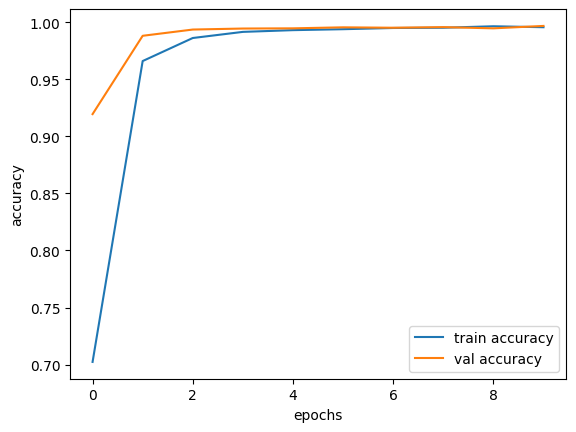

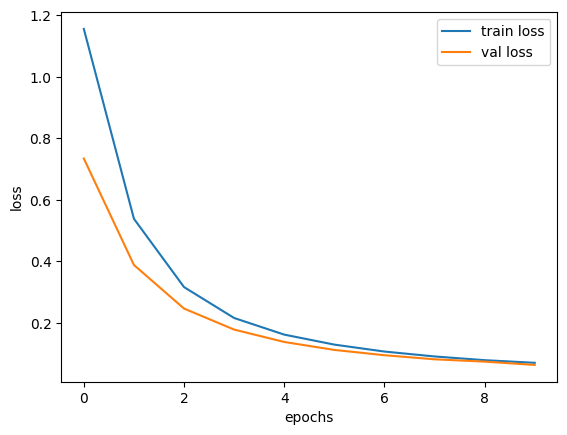

In [4]:
from CNNBiLSTM_LoadData import draw_history
draw_history(history,10)